## `Processes vs Threads`

**Here we will look at how processes and threads in python allow (or don't) speed up the execution of two major classes of tasks -- cpu bound and input output bound. I have prepared functions that mimic these tasks in the `important_library.py` file. Feel free to take a look :)**

In [1]:
import time
from concurrent import futures
from tqdm import tqdm
from important_library import io_task, cpu_task
import psutil

In [2]:
def run_example(n_workers: 'int', n_tasks: 'int', workload: 'str', worker: 'str') -> 'None':
    pool_executor = futures.ThreadPoolExecutor if worker == "thread" else futures.ProcessPoolExecutor
    with pool_executor(n_workers) as executor:
        routine = io_task if workload == "io" else cpu_task
        tasks = [executor.submit(routine, ) for _ in range(n_tasks)]
        for task in tqdm(futures.as_completed(tasks), total=len(tasks)):
            _ = task.result()

In [3]:
for workload in ["cpu", "io"]:
    for n_workers, n_tasks in [(1, 24), (2, 24)]:
        start = time.time()
        run_example(n_workers=n_workers, n_tasks=n_tasks, workload=workload, worker="thread")
        print(f"[# threads = {n_workers}, # tasks = {n_tasks}, workload = {workload}]")
        print(f"Total time {time.time() - start:0.4f} s")
        print("-" * 60)

100%|██████████| 24/24 [00:00<00:00, 87.65it/s] 


[# threads = 1, # tasks = 24, workload = cpu]
Total time 0.6310 s
------------------------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 139.97it/s]


[# threads = 2, # tasks = 24, workload = cpu]
Total time 0.6166 s
------------------------------------------------------------


100%|██████████| 24/24 [01:09<00:00,  2.89s/it]


[# threads = 1, # tasks = 24, workload = io]
Total time 69.4541 s
------------------------------------------------------------


100%|██████████| 24/24 [00:45<00:00,  1.89s/it]

[# threads = 2, # tasks = 24, workload = io]
Total time 45.4068 s
------------------------------------------------------------


In [4]:
for workload in ["cpu", "io"]:
    for n_workers, n_tasks in [(1, 24), (2, 24)]:
        start = time.time()
        run_example(n_workers=n_workers, n_tasks=n_tasks, workload=workload, worker="process")
        print(f"[# processes = {n_workers}, workload = {workload}]")
        print(f"Total time {time.time() - start:0.4f} s")
        print("-" * 60)

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:00<00:00, 35.09it/s]

[# processes = 1, workload = cpu]
Total time 0.7013 s
------------------------------------------------------------



100%|██████████| 24/24 [00:00<00:00, 68.16it/s]

[# processes = 2, workload = cpu]
Total time 0.3638 s
------------------------------------------------------------



100%|██████████| 24/24 [01:09<00:00,  2.90s/it]

[# processes = 1, workload = io]
Total time 69.5136 s
------------------------------------------------------------



100%|██████████| 24/24 [00:48<00:00,  2.01s/it]

[# processes = 2, workload = io]
Total time 48.2397 s
------------------------------------------------------------


**It's more faster and scalable to use processes in every way. What's the catch?**

**Let's take a look at resource consumption ...**

In [5]:
def print_mem():
    total_memory = 0
    for proc in psutil.process_iter(['pid', 'name', 'memory_info']):
        if 'Python' in proc.info['name']:
            total_memory += proc.info['memory_info'].rss
    print(f"Total Python's memory: {total_memory / 1024 / 1024} MB")

In [12]:
!echo 'the number of active python processes:' && ps aux | grep '[p]ython' | wc -l | awk '{print $1}'

the number of active python processes:
3


In [13]:
print_mem()

Total Python's memory: 61.703125 MB


**Oh, shit! It's about `20mB` per process! Maybe we can make the threads and tasks work together somehow ? ;(**

**To do it we need to understand the reason on problem. It is `GIL` (read my [post](link) for details or google it)**

## `Execution workflow`

In [14]:
import dis
import py_compile
import marshal

**Let me show what is byte code of the function.**

In [15]:
def print_slogan():
    print("The real science")

In [16]:
dis.dis(print_slogan)

  2           0 LOAD_GLOBAL              0 (print)
              2 LOAD_CONST               1 ('The real science')
              4 CALL_FUNCTION            1
              6 POP_TOP
              8 LOAD_CONST               0 (None)
             10 RETURN_VALUE


**Also we can call compile it by ourselves:**

In [17]:
file = "/Users/zinchse/GitHub/parallel_python/important_library.py"
path_to_compiled_file = py_compile.compile(file)

with open(path_to_compiled_file, 'rb') as f:
    f.read(16) 
    code = marshal.load(f)
    dis.dis(code)

  1           0 SETUP_ANNOTATIONS
              2 LOAD_CONST               0 (0)
              4 LOAD_CONST               1 (None)
              6 IMPORT_NAME              0 (time)
              8 STORE_NAME               0 (time)

  4          10 LOAD_CONST               2 (1000000)
             12 STORE_NAME               1 (N_ITER)
             14 LOAD_CONST               3 ('int')
             16 LOAD_NAME                2 (__annotations__)
             18 LOAD_CONST               4 ('N_ITER')
             20 STORE_SUBSCR

  7          22 LOAD_CONST               3 ('int')
             24 LOAD_CONST               5 (('return',))
             26 BUILD_CONST_KEY_MAP      1
             28 LOAD_CONST               6 (<code object cpu_task at 0x107c267c0, file "/Users/zinchse/GitHub/parallel_python/important_library.py", line 7>)
             30 LOAD_CONST               7 ('cpu_task')
             32 MAKE_FUNCTION            4 (annotations)
             34 STORE_NAME               3 (c

In [18]:
for instr in dis.Bytecode(io_task):
    print(instr.opname)

LOAD_GLOBAL
LOAD_GLOBAL
CALL_FUNCTION
GET_ITER
FOR_ITER
STORE_FAST
LOAD_GLOBAL
LOAD_METHOD
LOAD_CONST
CALL_METHOD
POP_TOP
JUMP_ABSOLUTE
LOAD_CONST
RETURN_VALUE


**Hm. It really works!**

## `Cython vs GIL`

**To avoid `GIL`, as we already know (see link to post in `README`), we can rewrite the most heavily loaded part of the program in `Cython`, so that it no longer requires a lock interpreter for its execution, and can be truly parallelized on different processor cores. Let's do it!**

### `Preparation`

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from timeit import repeat

In [20]:
def master(l: 'int', r: 'int', n_jobs: 'int', n_steps: 'int', routine: 'Callable'): 
    subranges, subrange_length = [], (r - l) / n_jobs
    cur_l = 0
    for i in range(n_jobs):
        cur_l = i * subrange_length
        cur_r = (i + 1) * subrange_length
        subranges.append((cur_l, cur_r))
    
    results = 0
    with futures.ThreadPoolExecutor(n_jobs) as executor:
        tasks = [executor.submit(routine, l, r, n_steps // n_jobs) for l, r in subranges]
        for task in futures.as_completed(tasks):
            results += task.result()
    
    return results

**just remind, the integral of $x ^ 2$ on the range $[a, b]$ is $$(b ^ 3 - a ^ 3) \cdot \frac{1}{b - a}$$**

**I have already written implementations of the integrate function in `Cython` and `Python` (see the files `integrate_square_c.pyx` and `integrate_square_py.py`, respectively).**

**To use the C implementation, however, you must first compile it in a special way, and subload one library so that it can use the c code as if it were a regular python procedure:**

In [24]:
!cythonize -i integrate_square_c
import pyximport
pyximport.install()
# from integrate_square_c import inegrate_square as integrator_c
import integrate_square_c
integrator_c = integrate_square_c.integrate_square
from integrate_square_py import integrate_square as integrator_py

In [25]:
res = master(l=0, r=5, n_jobs=10, n_steps=1_000_000, routine=integrator_py)
assert np.isclose(res, 5 ** 3 / 3), "Need to increase `n_steps`!"
print("Master with Python's implementation works")

Master with Python's implementation works


In [26]:
res = master(l=0, r=5, n_jobs=10, n_steps=100_000_000, routine=integrator_c)
assert np.isclose(res, 5 ** 3 / 3), "Need to increase `n_steps`!"
print("Master with Cython's implementation works")

Master with Cython's implementation works


### `Let's compare them!`

In [27]:
def plot_dependency(l: 'float', r: 'float', n_jobs_to_try: 'List[int]', n_steps: 'int', save: 'bool' = False):
    py_times = []
    c_times = []
    
    for n_jobs in n_jobs_to_try:
        py_times.append(
            1000 * np.mean(repeat(lambda: master(l, r, n_jobs, n_steps, integrator_py), number=1, repeat=10))
        )
        c_times.append(
            1000 * np.mean(repeat(lambda: master(l, r, n_jobs, 100 * n_steps, integrator_c), number=1, repeat=10))
        )
    
    plt.style.use("dark_background")
    _, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.title(f"Cython threads (\wo GIL) vs Python threads (\w GIL) on CPU bound task")
    for times, color, label in ((py_times, "cyan", "Python"), (c_times, "orange", "Cython")):
        ax.plot(
            n_jobs_to_try, times, marker='o', color=color,
            label=label, alpha=0.8, linewidth=7, markersize=20
        )
    ax.set_xlabel('# Threads')
    ax.set_ylabel('Time (ms)')
    ax.grid(True)
    ax.legend()
    ax.set_xlim([0.5, n_jobs_to_try[-1] + 0.5])
    ax.set_ylim([0.0, max(c_times + py_times) * 1.15])
    if save:
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        ax.spines['left'].set_color('gray')
        ax.spines['right'].set_color('gray')
        ax.title.set_color('gray')
        ax.xaxis.label.set_color('gray')
        ax.yaxis.label.set_color('gray')
        ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
        plt.savefig('cython_vs_python.png', transparent=True)
    plt.show()
    

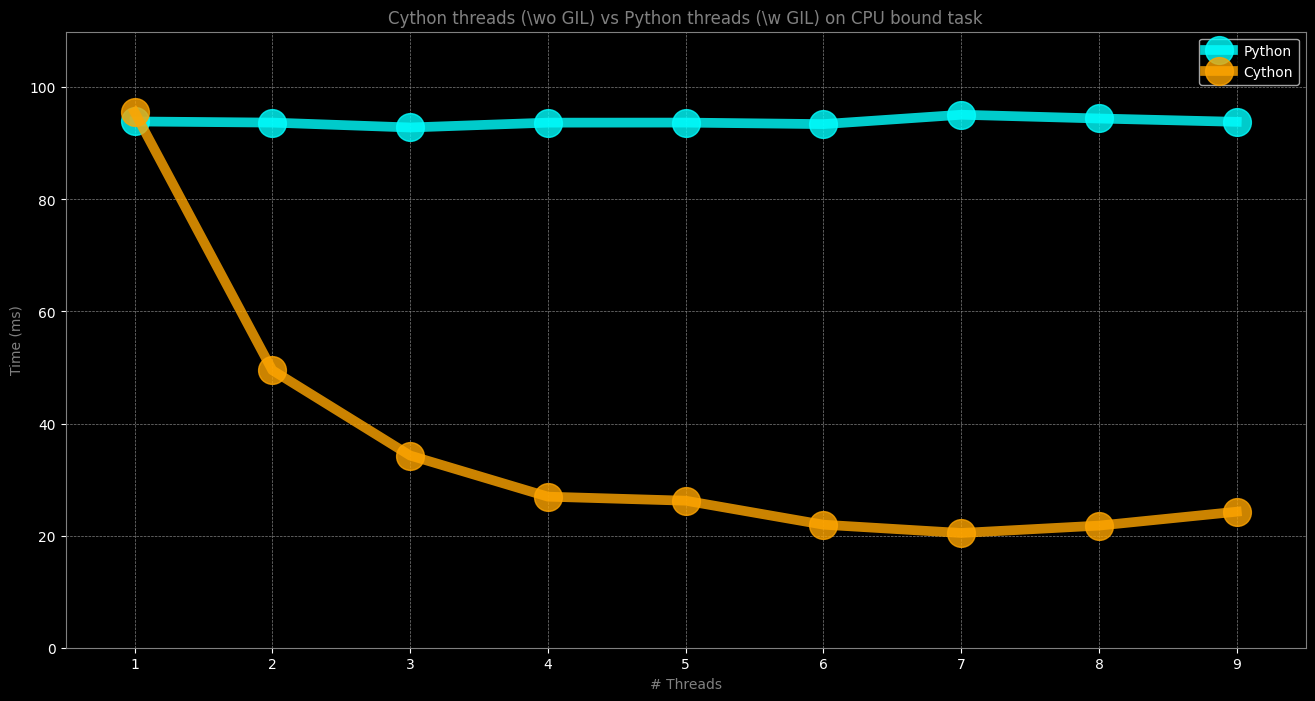

In [28]:
plot_dependency(0, 5, range(1, 10), 1_000_000, save=True)

### `Conclusion`

**`Cython` can really help us use threads in python to speed up CPU related tasks!**.

# Fun

## `Python & GIL & parallelism`

**Despite the fact that every thread holds a lock on the interpreter at runtime, race condition is still possible. Without further ado, let's just get it:**

In [29]:
import threading

In [30]:
def increment(v):
    for _ in range(v):
        global x
        x += 1

In [43]:
x = 0
t1 = threading.Thread(target=increment, args=(1000000, ))
t2 = threading.Thread(target=increment, args=(1000000, ))
t1.start()
t2.start()
t1.join()
t2.join()
assert x == 1000000 + 1000000, f"Oops :( x={x}"
print("We are lucky")

AssertionError: Oops :( x=1426306

## `Thief Thread`

**Because of the fact that in python locks can be released by more than just their owner, any coroutines can release a lock for itself if desired.**

In [44]:
class Money():
    def __init__(self):
        self.money: 'int' = 0
        self._lock: 'threading.Lock' = threading.Lock()

    def get(self, v: 'int') -> 'bool':
        with self._lock:
            if self.money >= v:
                self.money -= v
                print(f"/* getting {v}$ */")
                return True
            else:
                print(f"Sorry, not enough money ({v} vs {self.money})")
                return False
                
    def put(self, v: 'int') -> 'None':
        with self._lock:
            print(f"/* putting {v}$ */")
            self.money += v
                
    def lock(self) -> 'None':
        self._lock.acquire()
        
    def unlock(self) -> 'None':
        self._lock.release()
        
    def get_state(self) -> 'None':
        print(
            {
                "lock is closed": self._lock.locked(),
                "amount of money ($)": self.money
            }
        )

In [45]:
my_money = Money()
my_money.put(1000)
my_money.lock()
my_money.get_state()

/* putting 1000$ */
{'lock is closed': True, 'amount of money ($)': 1000}


In [46]:
def thief_thread():
    print("[thief]: I am here.")
    my_money.get_state()
    if my_money._lock.locked():
        print("[thief]: Hm. It seems that money is locked. Lets unlock it ...")
        my_money.unlock()        
    if my_money.get(1000 - 7):
        print("[thief]: Easy")
    else:
        print("[thied]: Very little money. I will leave it to the poor.")
    my_money.get_state()

In [47]:
t = threading.Thread(target=thief_thread)
t.start()
t.join()

[thief]: I am here.
{'lock is closed': True, 'amount of money ($)': 1000}
[thief]: Hm. It seems that money is locked. Lets unlock it ...
/* getting 993$ */
[thief]: Easy
{'lock is closed': False, 'amount of money ($)': 7}


## `Unbouded Semaphore`

**Similarly with semaphores. They can be released even if you don't own them. Because of this, a 1-semaphora that should logically work as a loc can exhibit very different behavior ...**

In [52]:
semaphore = threading.Semaphore(1)

In [53]:
def worker(thread_id):
    with semaphore:
        print(f"Thread {thread_id} has acquired the semaphore and is working", flush=True)
        time.sleep(0.1)
        print(f"Thread {thread_id} is doing some work ...", flush=True)
        time.sleep(2)
        print(f"Thread {thread_id} has released the semaphore", flush=True)
        time.sleep(0.1)

In [54]:
def do_work(use_bug: 'bool'):
    if use_bug:
        for _ in range(2):
            semaphore.release(1)
    threads = []
    for i in range(3):
        thread = threading.Thread(target=worker, args=(i, ))
        threads.append(thread)
        thread.start()
        
    for thread in threads:
        thread.join()
    print("All threads have finished")

In [55]:
do_work(use_bug=False)

Thread 0 has acquired the semaphore and is working
Thread 0 is doing some work ...
Thread 0 has released the semaphore
Thread 1 has acquired the semaphore and is working
Thread 1 is doing some work ...
Thread 1 has released the semaphore
Thread 2 has acquired the semaphore and is working
Thread 2 is doing some work ...
Thread 2 has released the semaphore
All threads have finished


**We see, that basicly `Semaphore(1)` works like `Lock` (as exptected), but ...**

In [56]:
semaphore = threading.Semaphore(1)

In [57]:
do_work(use_bug=True)

Thread 0 has acquired the semaphore and is working
Thread 1 has acquired the semaphore and is working
Thread 2 has acquired the semaphore and is working
Thread 1 is doing some work ...
Thread 0 is doing some work ...Thread 2 is doing some work ...

Thread 1 has released the semaphore
Thread 2 has released the semaphoreThread 0 has released the semaphore

All threads have finished


**With `use_bug=True` it doesn't work as `Lock`!**

### `Conclusion`

**If you want to read more about what went on here, you can read my post (see `README`), there are also links to all the resources used and more detailed sources of information. You can also check out the presentation in this repository**.